# tdsm encoder
Here provides the interface of interacting with function in `util` to perform the training & sampling of generative model. 

## import model

In [1]:
import time, functools, torch, os,sys, random, fnmatch, psutil
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import Adam
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import util.dataset_structure, util.display, util.model
import tqdm

## Parameter setting

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
padding_value = -20

dataset = "dataset_2" # toy_model/dataset_1_photons
dataset_store_path = "/eos/user/t/tihsu/database/ML_hackthon/bucketed_tensor"
transform = None
transform_y = None
mask = True

### Pad data (Optional)
Please try until it works

In [3]:
files_lists = []
for filename in os.listdir(dataset_store_path):
    if fnmatch.fnmatch(filename, dataset + '*.pt'):
        files_lists.append(os.path.join(dataset_store_path, filename))
#print(files_lists)
files_lists = files_lists[:2]
tqdm_file = tqdm.notebook.trange(len(files_lists))
os.system("mkdir -p samples")
for index in tqdm_file:
    file_name = files_lists[index]
    data = util.dataset_structure.cloud_dataset(file_name, device=device)
    data.transformed()
    print(data.condition.dtype)
    data.padding()
    data.save(os.path.join("samples", (file_name.split('/')[-1]).replace('no_pedding','padding')))

  0%|          | 0/2 [00:00<?, ?it/s]

/eos/home-i00/t/tihsu/SWAN_projects/ML_hackathon/tdsm_encoder/util/dataset_structure.py:47: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



torch.float32
1269
torch.float32
torch.float32
1410
torch.float32


### Training parameter

In [4]:
batch_size = 50
lr = 0.0001
n_epochs = 200
workingdir = "./"
batch_size = 150
train_ratio = 0.9

sigma = 25.0
vesde = util.dataset_structure.VESDE(device=device)
new_marginal_prob_std_fn = functools.partial(vesde.marginal_prob)
new_diffusion_coeff_fn   = functools.partial(vesde.sde)

print('torch version: ', torch.__version__)
print('Running on device: ', device)
if torch.cuda.is_available():
    print('Cuda used to build pyTorch: ',torch.version.cuda)
    print('Current device: ', torch.cuda.current_device())
    print('Cuda arch list: ', torch.cuda.get_arch_list())

print('Working directory: ', workingdir)

files_list_ = []
for filename in os.listdir(dataset_store_path):
    if fnmatch.fnmatch(filename, '*' + dataset + '*.pt'):
        files_list_.append(os.path.join('samples', filename).replace('no_pedding','padding'))
print(files_list_)

n_features = 4
embed_dim = 64
hidden_dim = 128
n_transformer = 6
n_head  = 4
dropout = 0
model = util.model.Gen(n_features, embed_dim, hidden_dim, n_transformer, n_head, dropout, marginal_prob_std=new_marginal_prob_std_fn)
print('model: ', model)

if mask:
    mask_label = 'mask'
else:
    mask_label = 'no_mask'

# Debug
files_list_ = files_list_[:2]
label = f'embed{embed_dim}_hid{hidden_dim}_{n_transformer}trans_{n_head}head_dropout{dropout}_{mask_label}'
print('label:', label)
print(files_list_)

torch version:  1.13.0a0
Running on device:  cuda
Cuda used to build pyTorch:  11.8
Current device:  0
Cuda arch list:  ['sm_37', 'sm_50', 'sm_60', 'sm_61', 'sm_70', 'sm_75', 'compute_37']
Working directory:  ./
['samples/dataset_2_tensor_padding_euclidian_nentry1129To1269.pt', 'samples/dataset_2_tensor_padding_euclidian_nentry1270To1410.pt', 'samples/dataset_2_tensor_padding_euclidian_nentry1411To1551.pt', 'samples/dataset_2_tensor_padding_euclidian_nentry142To282.pt', 'samples/dataset_2_tensor_padding_euclidian_nentry1552To1692.pt', 'samples/dataset_2_tensor_padding_euclidian_nentry1693To1833.pt', 'samples/dataset_2_tensor_padding_euclidian_nentry1834To1974.pt', 'samples/dataset_2_tensor_padding_euclidian_nentry1975To2115.pt', 'samples/dataset_2_tensor_padding_euclidian_nentry1To141.pt', 'samples/dataset_2_tensor_padding_euclidian_nentry2116To2256.pt', 'samples/dataset_2_tensor_padding_euclidian_nentry2257To2397.pt', 'samples/dataset_2_tensor_padding_euclidian_nentry2398To2538.pt', '

## Plot data distribution (Optional)

/eos/home-i00/t/tihsu/SWAN_projects/ML_hackathon/tdsm_encoder/util/dataset_structure.py:45: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



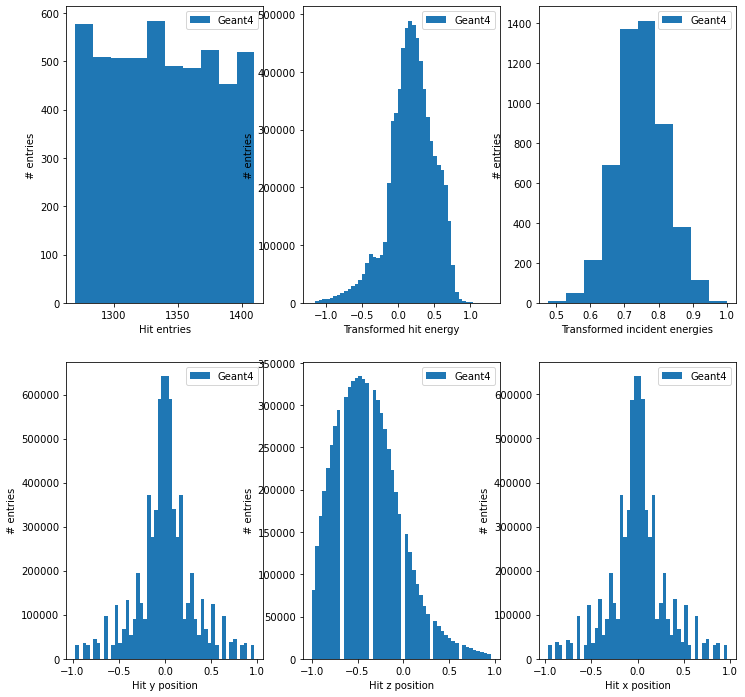

In [5]:
plot_file_name = "samples/dataset_2_tensor_padding_euclidian_nentry1270To1410.pt"
custom_data = util.dataset_structure.cloud_dataset(plot_file_name,device=device, transform=transform, transform_y=transform_y, transformed=True)
point_clouds_loader = DataLoader(custom_data, batch_size=150, shuffle=False)
fig = util.display.plot_distribution(point_clouds_loader, label="Geant4")
fig.show()

In [6]:
def display_event(point_clouds_loader, padding_value=-20, nEvent=10, start=0, rotate_angle=[-70,0], threshold=0):

    all_x = []
    all_y = []
    all_z = []
    all_e = []
    processed_nEvent = 0
    
    for i, (shower_data,incident_energies) in enumerate(point_clouds_loader,0):

        valid_event = []
        data_np = shower_data.cpu().numpy().copy()
        mask = ~(data_np[:,:,3] == padding_value)
        mask_threshod = data_np[:,:,3]>threshold

        for j in range(len(data_np)):
            if processed_nEvent >= start:
                valid_event = data_np[j][mask[j]]
                mask_threshold = valid_event[:,3]>threshold
                valid_event = valid_event[mask_threshold]
                if len(valid_event) > 0:
                    all_e += ((valid_event).copy()[:,0]).flatten().tolist()
                    all_x += ((valid_event).copy()[:,1]).flatten().tolist()
                    all_y += ((valid_event).copy()[:,2]).flatten().tolist()
                    all_z += ((valid_event).copy()[:,3]).flatten().tolist()
            processed_nEvent += 1
            if processed_nEvent-start >= nEvent: break
        if processed_nEvent-start >= nEvent: break

    print(processed_nEvent)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('z')

    img = ax.scatter(all_x, all_y, all_z, c=all_e)
    fig.colorbar(img)
    ax.view_init(rotate_angle[0],rotate_angle[1])

2


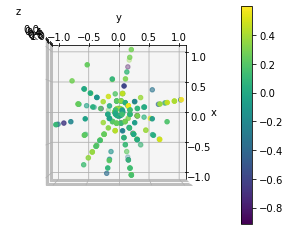

In [27]:
display_event(point_clouds_loader, nEvent = 1, start = 1, rotate_angle=[-90,0], threshold=0.0)

## Training

### Start to train!!

Output directory:  training_result/embed64_hid128_6trans_4head_dropout0_mask/


  0%|          | 0/200 [00:00<?, ?it/s]

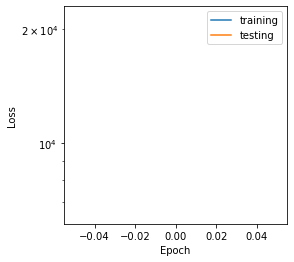

/eos/home-i00/t/tihsu/SWAN_projects/ML_hackathon/tdsm_encoder/util/dataset_structure.py:47: UserWarning:

To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).



KeyboardInterrupt: 

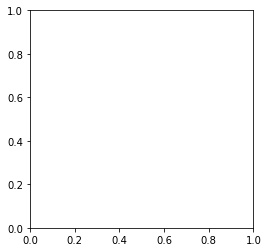

In [4]:
torch.cuda.empty_cache()
util.model.training(batch_size = batch_size,
                    lr = lr,
                    n_epochs = n_epochs,
                    model = model,
                    new_marginal_prob_std_fn = new_marginal_prob_std_fn,
                    device = device,
                    jupyternotebook = True,
                    files_list = files_list_,
                    train_ratio = train_ratio,
                    mask=mask, padding_value=padding_value,
                    label=label,
                    transform = transform,
                    transform_y = transform_y)

In [28]:
a = torch.cuda.memory_allocated(device=device)/1024/1024/1024
print(a)
print(files_list_)

0.22056245803833008
['samples/dataset_2_tensor_padding_euclidian_nentry1129To1269.pt', 'samples/dataset_2_tensor_padding_euclidian_nentry1270To1410.pt']


output_directory: sampling/embed64_hid128_6trans_4head_dropout0_mask
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]] [0.47680053 0.47732373 0.47784693 ... 0.9989536  0.9994768  1.        ] [1129.    1129.281 1129.562 ... 1409.438 1409.719 1410.   ]
1411
Progress: 1/2

  0%|          | 0/100 [00:00<?, ?it/s]

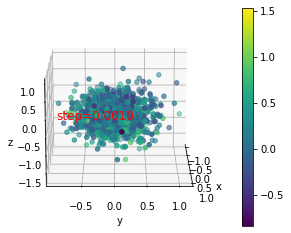

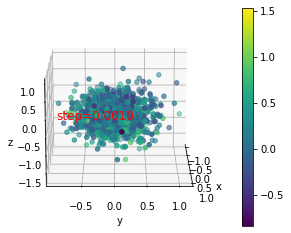

Progress: 2/2

  0%|          | 0/100 [00:00<?, ?it/s]

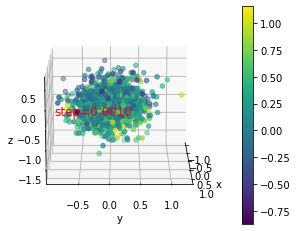

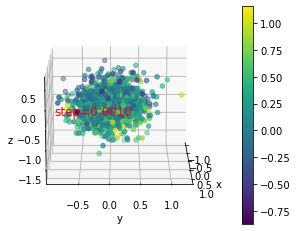

In [6]:
hits_energies = torch.rand(200)
sample, in_energies, nhits, hist = util.model.generate_sample(model=model,
                                                        marginal_prob_std=new_marginal_prob_std_fn, 
                                                        diffusion_coeff=new_diffusion_coeff_fn,
                                                        sample_batch_size=150,
                                                        n_bin=1000,
                                                        load_name = "training_result/"+label+"/ckpt_tmp_103.pth",
                                                        device=device,
                                                        in_energies=hits_energies,
                                                        sampled_file_list=files_list_,
                                                        mask=mask, 
                                                        jupyternotebook=True,
                                                        label = label,
                                                        transform = transform,
                                                        transform_y = transform_y,
                                                        padding_value=-20,
                                                        video=True,
                                                        rotate_angle=[15,0])

In [5]:
print(hist)
while(hist.sum()<1000):
    index = np.arange(0,1000)[hist.sum(axis=-1)<1]
    hist[index,:] = hist[index-1,:]
print(hist.sum(axis=-1))

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1

## Draw Generative Distribution

1411


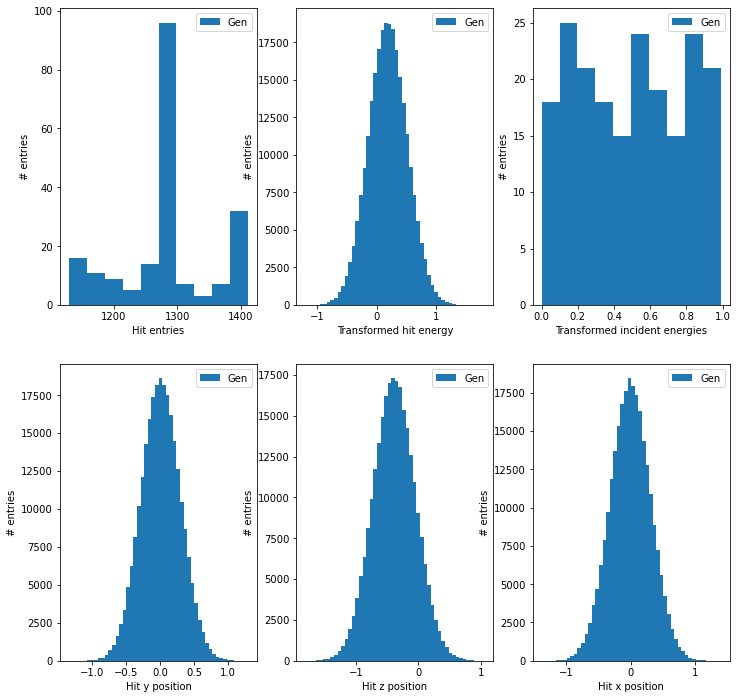

In [4]:
plot_file_name = "sampling/"+label+"/sample.pt"
custom_data = util.dataset_structure.cloud_dataset(plot_file_name,device='cpu', transform = transform, transform_y=transform_y, transformed=True)
#custom_data.digitize()
custom_data.padding()
point_clouds_loader_gen = DataLoader(custom_data, batch_size=150, shuffle=False)
fig = util.display.plot_distribution(point_clouds_loader_gen, label="Gen")
fig.show()

9


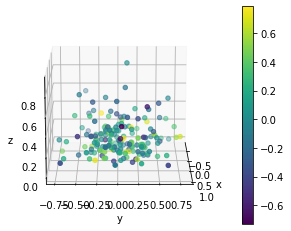

In [55]:
display_event(point_clouds_loader_gen, nEvent = 1, start = 8, rotate_angle=[15,0], threshold=0.0)

In [56]:
custom_data = util.dataset_structure.cloud_dataset(files_list_[0],device=device, transform = transform, transform_y=transform_y, transformed=True)
custom_data.padding()
point_clouds_loader_truth = DataLoader(custom_data, batch_size=150, shuffle=False)
print(files_list_[0])

1269
samples/dataset_2_tensor_padding_euclidian_nentry1129To1269.pt


100


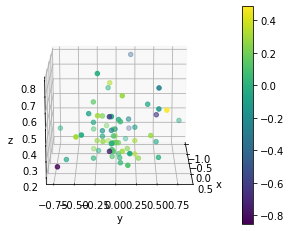

In [58]:
display_event(point_clouds_loader_truth, nEvent = 1, start = 99, rotate_angle=[15,0],threshold=0.0)